# Sciplex2
In this notebook, we load the sciplex2 dataset (1 cell line, 4 drugs, 7 dosages).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors


In [2]:
# change this to the directory that contains the datasets
data_dir = 'C:/Users/nbrouwer1/Documents/VS_projects/prepare_data/input_files/sciplex_selections/'

fn = data_dir + 'sciPlex2_A549_all4_drugs_and_doses.h5ad'

adata_orig = sc.read_h5ad(fn)
adata_orig

c:\Users\nbrouwer1\Documents\VS_projects\prepare_data\.conda\lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 20964 × 35653
    obs: 'i', 'n.umi', 'Size_Factor', 'drug', 'dose', 'count genes expressed', 'ratio mt2non_mt'
    var: 'Ensemble Id'

In [3]:
adata_orig.var_names_make_unique()

Count number of gene counts per cell.

<class 'numpy.ndarray'> (20964,)


C:\Users\nbrouwer1\AppData\Local\Temp\ipykernel_17628\326829190.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  adata_orig.obs.count_orig = vec_count_sum_orig


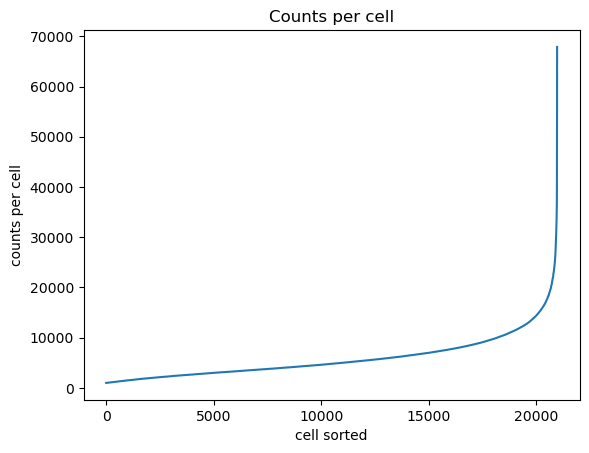

In [4]:
vec_count_sum_orig = adata_orig.X.sum(axis = 1)
vec_count_sum_orig = np.asarray(vec_count_sum_orig).ravel() 
print(type(vec_count_sum_orig), vec_count_sum_orig.shape)
plt.plot( np.sort(vec_count_sum_orig  ) )
plt.xlabel('cell sorted')
plt.ylabel('counts per cell')
plt.title('Counts per cell')
adata_orig.obs.count_orig = vec_count_sum_orig

Apply some standard preprocessing steps.

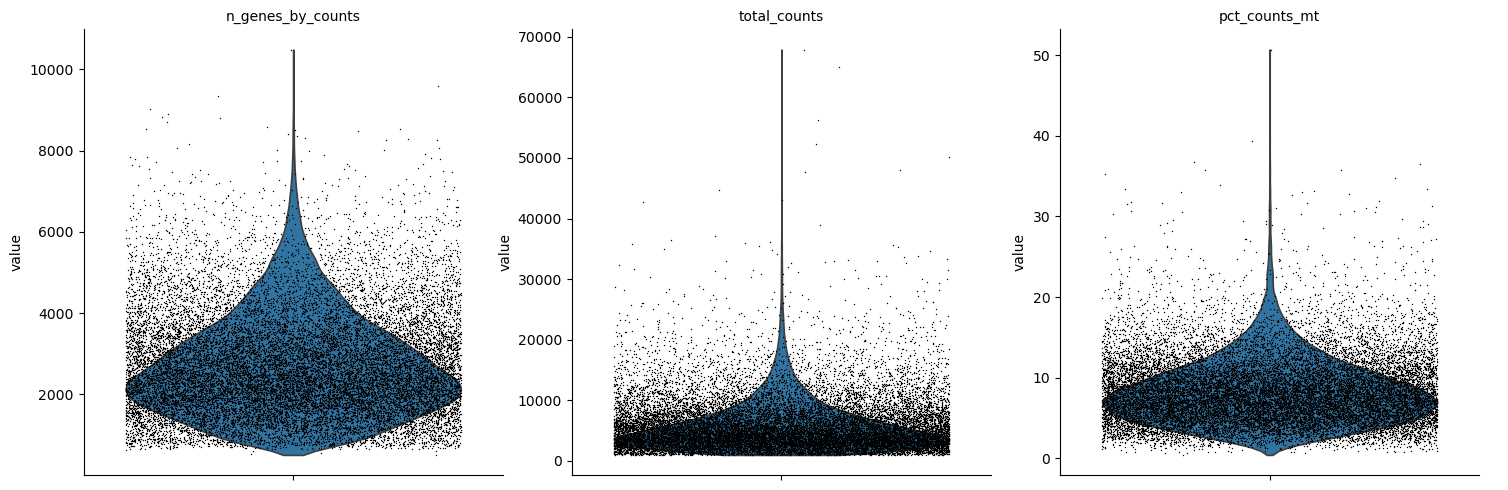

Median total counts = 4811.0
min_count= 500 max_count= 12000


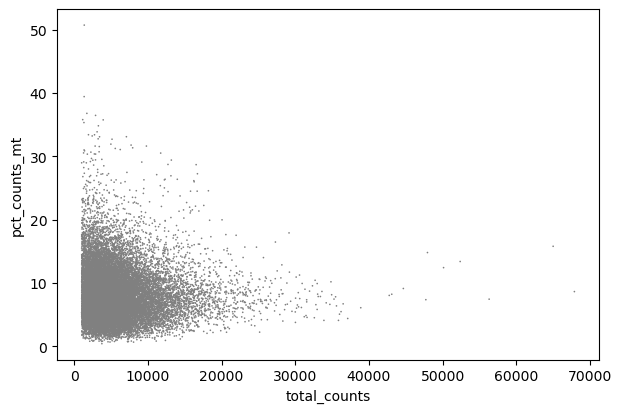

19240 samples pass the count filter
20963  samples pass the mt filter
Samples selected 19239


c:\Users\nbrouwer1\Documents\VS_projects\prepare_data\.conda\lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\nbrouwer1\Documents\VS_projects\prepare_data\.conda\lib\site-packages\scanpy\preprocessing\_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


(19239, 30)

In [5]:
adata = adata_orig

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

#sv.pp.remove_duplicate_cells(adata)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

median_count = np.median(adata.obs['total_counts'])
print('Median total counts =',median_count)
min_count = np.max((median_count/2,5000))

min_count = 500
max_count = 12000

print('min_count=',min_count,'max_count=',max_count)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
inds1 = np.where((adata.obs['total_counts']>min_count) & (adata.obs['total_counts']<max_count))
inds2 = np.where(adata.obs['pct_counts_mt']<50)
print(len(inds1[0]),'samples pass the count filter')
print(len(inds2[0]),' samples pass the mt filter')
ind_samples = np.intersect1d(inds1[0],inds2[0])
print('Samples selected',len(ind_samples))
adata.uns['ind_samples'] = ind_samples

# Here we cut cells. Filtering out those with counts too low or too big
adata = adata[ind_samples,:]

if False:
    X = adata.X.T
    with open(dataset_name+'_umi.txt','w') as f:
        sample_names = list(adata.obs_names)
        f.write('GENE\t'+'\t'.join(sample_names)+'\n')
        print('Number of genes = ',adata.X.shape[1])
        for i in range(adata.X.shape[1]):
            vals = [str(X[i,k]).replace('.0','') for k in range(X.shape[1])]
            f.write(adata.var_names[i]+'\t'+'\t'.join(vals)+'\n')
    print('Saved.')
    
    
sc.pp.normalize_total(adata, target_sum=np.median(adata.obs["total_counts"]))
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=10001,n_bins=20)
ind_genes = np.where(adata.var['highly_variable'])[0]

adata = adata[:,ind_genes]
sc.tl.pca(adata,n_comps=30)
X_pca = adata.obsm['X_pca']

adata_orig[ind_samples,ind_genes].var.shape
XX2 = adata_orig[ind_samples,ind_genes].X.toarray()
adata =  anndata.AnnData(XX2,  obs=adata_orig[ind_samples,ind_genes].obs.copy(), 
                     var=adata_orig[ind_samples,ind_genes].var.copy() ) #
adata


X_pca1 = X_pca.copy()
X_pca.shape

Normalize the counts.

In [6]:
print(adata.X[:5,:5])
sc.pp.normalize_total(adata, target_sum=np.median(adata.obs["total_counts"]))
sc.pp.log1p(adata)
print(adata.X[:5,:5])


[[0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0.]
 [0. 0. 0. 4. 0.]
 [0. 0. 1. 0. 0.]]
[[0.        0.        0.        0.        0.       ]
 [0.        0.        0.        2.447869  0.       ]
 [1.7642055 0.        0.        1.7642055 0.       ]
 [0.        0.        0.        2.4208386 0.       ]
 [0.        0.        1.3052132 0.        0.       ]]


## Visualisation
Use PCA or UMAP to visualize the dataset.
The cells are colored based on drug and dose labels.

In [15]:
sc.tl.pca(adata,n_comps=30)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

c:\Users\nbrouwer1\Documents\VS_projects\prepare_data\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


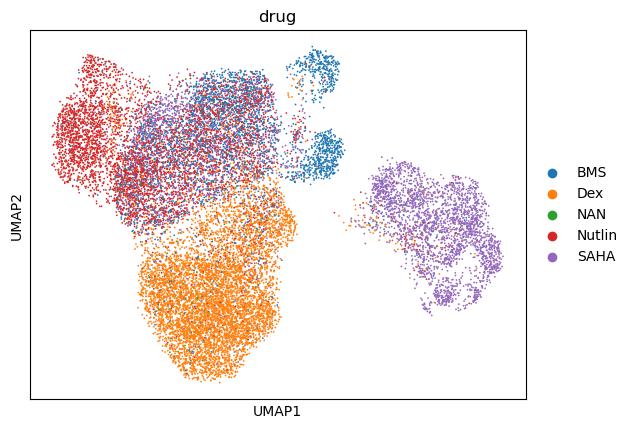

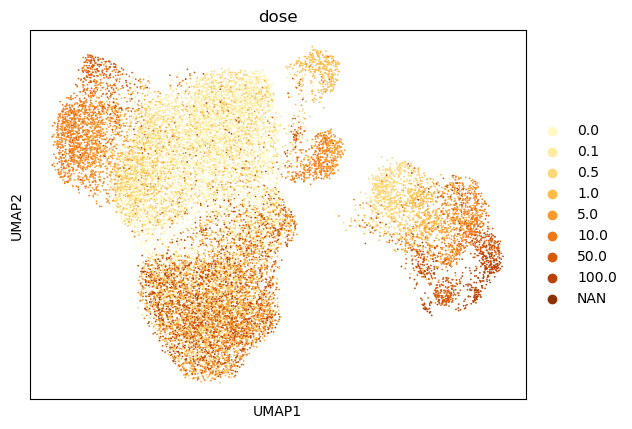

In [16]:
sc.pl.umap(adata, color='drug' )
sc.pl.umap(adata, color='dose', palette=sns.color_palette("YlOrBr", 9))